# Circadian Simulation of Goldbeter's Circadian Oscillator Model

Author: Shao-Ting Chiu (stevengogogo@gm.ym.edu.tw)


## Goldbeter's model - Circadian Oscillator of PER


### Scheme of PER Oscillator

<img src="img/MODEL_circadian_goldbeter1996.png">
*Source: Ingalls, B. P. (2013). *


### Mathematical Formula - ODE System

$$\frac{d}{dt}m(t) = \frac{v_s}{1+(p_N(t)/K_I)^n} - \frac{v_m m(t)}{K_{m1} + m(t)}$$

$$\frac{d}{dt}p_0(t) = k_s m(t) - \frac{V_1 p_0(t)}{K_1 + p_0(t)} + \frac{V_2p_1(t)}{K_2 + p_1(t)}$$

$$\frac{d}{dt}p_1(t) = \frac{V_1p_0(t)}{K_1 + p_0(t)} - \frac{V_2p_1(t)}{K_2 + p_1(t)} - \frac{V_3p_1(t)}{K_3 + p1(t)} + \frac{V_4p_2(t)}{K_4+p_2(t)}$$

$$\frac{d}{dt}p_2(t) = \frac{V_3p_1(t)}{K_3 + p_1(t)} - \frac{V_4p_2(t)}{K_4 + p_2(t)} - k_1p_2(t) + k_2p_N(t) - \frac{v_d p_2(t)}{K_d + p_2(t)}$$

$$\frac{d}{dt}p_N(t) = k_1p_2(t) - k_2p_N(t)$$



## References
1. Ingalls, B. P. (2013). Mathematical modeling in systems biology: an introduction. MIT press. ([link](https://books.google.com.tw/books?hl=zh-TW&lr=&id=OYr6AQAAQBAJ&oi=fnd&pg=PR5&dq=Ingalls,+B.+Mathematical+Modeling+in+Systems+Biology+-+an+Introduction.&ots=ucgsG0-NAA&sig=gXJPRtpiAQDzyLYYcGOT5CQBFVc&redir_esc=y#v=onepage&q=Ingalls%2C%20B.%20Mathematical%20Modeling%20in%20Systems%20Biology%20-%20an%20Introduction.&f=false))
2. Goldbeter, A. (1997). Biochemical oscillations and cellular rhythms: the molecular bases of periodic and chaotic behaviour. Cambridge university press. ([link](https://books.google.com.tw/books?hl=en&lr=&id=dKk0I-KMDJIC&oi=fnd&pg=PP1&ots=WVtd4X2-1N&sig=9pWRpEfrLnXo7kqvaTOfQBCpMUU&redir_esc=y#v=onepage&q&f=false))


--- 

In [ ]:
# Installation
using Pkg
Pkg.add(["ModelingToolkit","DifferentialEquations","Plots"])

In [3]:
# Module
using ModelingToolkit
using DifferentialEquations
using Plots
gr()

Plots.GRBackend()

In [4]:
#CHEMICAL REACTIONS
mm(v, k, sub) = v*sub/(k+sub)
hill(v,p,k,n) = v/(1+(p/k)^n)


function get_PER_MODEL()
    # Core Model. From Goldbeter, 1996
    # labels = ["mRNA(m)" "PER(p0)" "PER-P(p1)" "PER-PP(p2)" "PER-Nucleus(pn)"]
    #PARAMETERS
    @parameters t
    @parameters vs vm vd
    @parameters ks k1 k2
    @parameters V1 V2 V3 V4
    @parameters K1 K2 K3 K4 KI Km1 Kd n
    @variables m(t) p0(t) p1(t) p2(t) pn(t)
    @derivatives D'~t

    eqs = [
        D(m)  ~ hill(vs, pn, KI, n) - mm(vm, Km1, m),
        D(p0) ~ ks*m - mm(V1, K1,p0) + mm(V2, K2, p1),
        D(p1) ~ mm(V1, K1, p0) - mm(V2, K2,p1) - mm(V3, K3, p1) + mm(V4, K4, p2),
        D(p2) ~ mm(V3, K3, p1) - mm(V4, K4, p2) - k1*p2 + k2*pn - mm(vd,Kd,p2),
        D(pn) ~ k1*p2-k2*pn
    ]
    de = ODESystem(eqs)
    PER = ODEFunction(de,
                    [m,p0, p1, p2, pn],
                    [vs,vm,vd,ks,k1,k2,V1,V2,V3,V4,K1,K2,K3,K4,KI,Km1,Kd,n]
                    )

    return PER
end


function get_param(;vd=0.95)
    # From Goldbeter, 1996
    u0 = [2,0,2.0,2.0,2.0]
    p = (
        vs=0.76, vm=0.65, vd=vd,
        ks=0.38, k1=1.9, k2=1.3,
        V1=3.2, V2=1.58, V3=5.0, V4=2.5,
        K1=1.0, K2=1.0, K3=1.0, K4=1.0,
        KI=1.0, Km1=0.5, Kd=0.2, n=4.0
        )
    return u0, values(p)
end

function simulation(PER; vd=0.95)
    # The parameterset is from Ingalls
    #SET VALUE
    u0, p = get_param(vd=vd)
    tspan = (0.0, 100.0)

    #SOLVE
    prob = ODEProblem(PER, u0, tspan, p)
    sol = solve(prob)
    return sol
end

function solve_steady_state(PER;vd=0.95)
    u0, p = get_param(vd=vd)
    prob = SteadyStateProblem(PER, u0, p)
    cp = solve(prob, SSRootfind())
    return cp
end

solve_steady_state (generic function with 1 method)

In [5]:
# SETTING Simulation Parameters
vd = 0.95;
PER= get_PER_MODEL();
sol = simulation(PER; vd=vd);
cp = solve_steady_state(PER; vd=vd);

## Critical Point Therorem

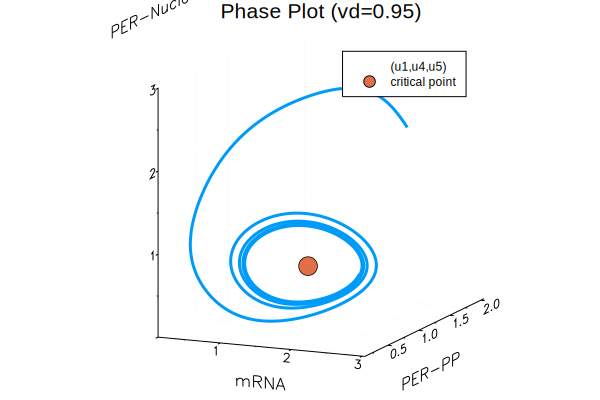

In [10]:
# Plotting   
labels = ["mRNA(m)" "PER(p0)" "PER-P(p1)" "PER-PP(p2)" "PER-Nucleus(pn)"]
plot_num = (1, 4, 5);

# Phase Plot with critical point
plot(sol, vars=plot_num, title="Phase Plot (vd=$vd)", xlabel=labels[plot_num[1]], ylabel=labels[plot_num[2]], zlabel=labels[plot_num[3]])
plot!([cp[plot_num[1]]], [cp[plot_num[2]]], [cp[plot_num[3]]],markershape=:circle, markersize=10, label="critical point")
#savefig("img/phasePlot_criticalpoint_$vd")

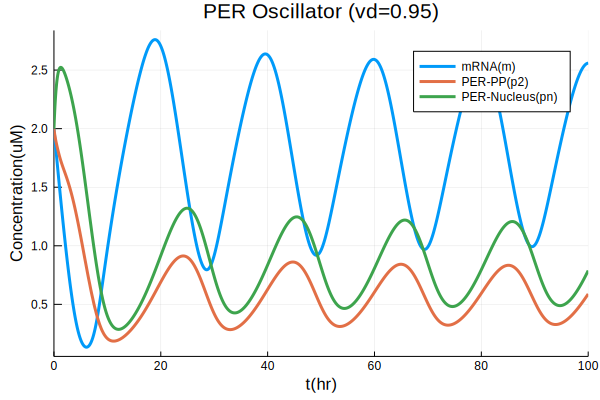

In [8]:
#Plot mRna, p2,pn
plot(sol, title="PER Oscillator (vd=$vd)", vars=collect(plot_num) , labels= labels[ collect(plot_num)' ])
ylabel!("Concentration(uM)")
xlabel!("t(hr)")
#savefig("img/timeSeries_three_$vd.png")

## Bendixson’s Criterion
If f x and g y are continuous in a region R which is simply-connected (i.e., without holes),


$$\frac{\partial f(x,y)}{\partial x} + \frac{\partial g(x,y)}{\partial y} \neq 0$$

at any point of R.



# Limit cycle 

$$m(t)' =  0.76 / (1 + (pn(t) / 1.0) ^ 4.0) - (0.65 * m(t)) / (0.5 + m(t))$$

$$p0(t)' = (0.38 * m(t) - (3.2 * p0(t)) / (1.0 + p0(t))) + (1.58 * p1(t)) / (1.0 + p1(t))$$

$$p1(t)' = (((3.2 * p0(t)) / (1.0 + p0(t)) - (1.58 * p1(t)) / (1.0 + p1(t))) - (5.0 * p1(t)) / (1.0 + p1(t))) + (2.5 * p2(t)) / (1.0 + p2(t))$$

$$p2(t)' = ((((5.0 * p1(t)) / (1.0 + p1(t)) - (2.5 * p2(t)) / (1.0 + p2(t))) - 1.9 * p2(t)) + 1.3 * pn(t)) - (vd * p2(t)) / (0.2 + p2(t))$$

$$pn(t)' = 1.9 * p2(t) - 1.3 * pn(t)$$

Let
- $\frac{\partial f_{m}}{\partial m} = \frac{-0.64(0.5+m) + 0.65}{(0.5+m)^2} = \frac{-0.325}{(0.5+m)^2}$
- $\frac{\partial g_{p2}}{\partial p2} = 

In [13]:
@parameters t
@parameters vs vm vd
@parameters ks k1 k2
@parameters V1 V2 V3 V4
@parameters K1 K2 K3 K4 KI Km1 Kd n
@variables m(t) p0(t) p1(t) p2(t) pn(t)
@derivatives D'~t

PER = get_PER_MODEL()


# PARAM
p = (
    vs=0.76, vm=0.65, vd=vd,
    ks=0.38, k1=1.9, k2=1.3,
    V1=3.2, V2=1.58, V3=5.0, V4=2.5,
    K1=1.0, K2=1.0, K3=1.0, K4=1.0,
    KI=1.0, Km1=0.5, Kd=0.2, n=4.0
    )

# MODEL
eqs = [
    D(m)  ~ hill(p.vs, pn, p.KI, p.n) - mm(p.vm, p.Km1, m),
    D(p0) ~ p.ks*m - mm(p.V1, p.K1,p0) + mm(p.V2, p.K2, p1),
    D(p1) ~ mm(p.V1, p.K1,p0) - mm(p.V2, p.K2,p1) - mm(p.V3, p.K3, p1) + mm(p.V4, p.K4, p2),
    D(p2) ~ mm(p.V3, p.K3, p1) - mm(p.V4, p.K4, p2) - p.k1*p2 + p.k2*pn - mm(p.vd,p.Kd,p2),
    D(pn) ~ p.k1*p2-p.k2*pn
]

for i in eqs
    println(i.rhs)
end



0.76 / (1 + (pn(t) / 1.0) ^ 4.0) - (0.65 * m(t)) / (0.5 + m(t))
(0.38 * m(t) - (3.2 * p0(t)) / (1.0 + p0(t))) + (1.58 * p1(t)) / (1.0 + p1(t))
(((3.2 * p0(t)) / (1.0 + p0(t)) - (1.58 * p1(t)) / (1.0 + p1(t))) - (5.0 * p1(t)) / (1.0 + p1(t))) + (2.5 * p2(t)) / (1.0 + p2(t))
((((5.0 * p1(t)) / (1.0 + p1(t)) - (2.5 * p2(t)) / (1.0 + p2(t))) - 1.9 * p2(t)) + 1.3 * pn(t)) - (vd * p2(t)) / (0.2 + p2(t))
1.9 * p2(t) - 1.3 * pn(t)


In [14]:
eqs

5-element Array{Equation,1}:
 Equation(derivative(m(t), t), 0.76 / (1 + (pn(t) / 1.0) ^ 4.0) - (0.65 * m(t)) / (0.5 + m(t)))                                                                    
 Equation(derivative(p0(t), t), (0.38 * m(t) - (3.2 * p0(t)) / (1.0 + p0(t))) + (1.58 * p1(t)) / (1.0 + p1(t)))                                                    
 Equation(derivative(p1(t), t), (((3.2 * p0(t)) / (1.0 + p0(t)) - (1.58 * p1(t)) / (1.0 + p1(t))) - (5.0 * p1(t)) / (1.0 + p1(t))) + (2.5 * p2(t)) / (1.0 + p2(t)))
 Equation(derivative(p2(t), t), ((((5.0 * p1(t)) / (1.0 + p1(t)) - (2.5 * p2(t)) / (1.0 + p2(t))) - 1.9 * p2(t)) + 1.3 * pn(t)) - (vd * p2(t)) / (0.2 + p2(t)))    
 Equation(derivative(pn(t), t), 1.9 * p2(t) - 1.3 * pn(t))                                                                                                         